In [1]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score

from tcn import TCN, tcn_full_summary

import warnings
warnings.filterwarnings("ignore")

2022-10-27 18:11:56.907204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[Predicting Sequential Data using LSTM: An Introduction](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

In [2]:
def calcW(m, k):
  return np.sqrt(k / m)

def calcTarget(a, b, w, time):
  return a * np.cos(w * time) + b * np.sin(w * time)

def makeTargetSet(a, b, m, k, times): #This is used to find the training time of the prediction
  w = calcW(m, k)
  return np.array(list([time, calcTarget(a, b, w, time)] for time in times)) #This is used to return the value for x(t) after every "time" step till it reaches "times" in seconds.

In this case we are assuming that the mass is vibrating in a **Simple Harmonic Motion**, this means that there is **zero external input forces** acting on this system. 
<br />In other words we can rearange the equation in the following form: $a=-\frac{k}{m}x$, or we can simplify it to this: $a=-{\omega_{n}}^2  x$. 
<br /> $\omega_{n}$ is the **natural frequency** of the object since the acceleration is directly proportional to the displacement in the opposite direction. From this equation, we can derive the natural frequency to be the following: $\omega_{n} = \sqrt\frac{k}{m}$ .

1. **x0:** The inital displacement usually measured in "m"
2. **v0:** The inital velocity usually measured in "m/s" 
2. **k:** The Stiffness Coefficent usually measured in "N/m"
3. **m:** The Mass usually measured in "kg"

To get the maximum Amplitude, you need to do the calculation: $\sqrt(A^2 + B^2)$

Now do note that the equation: $a=-{\omega_{n}}^2  x$ is an **Ordinary Differential Homogeneous Equation**. As a matter of fact we can re-arange our equations to be the following: $\frac{d^{2}x}{dt^{2}}+{\omega_{n}}^2  x = 0$ and if we have the intial conditon of displacement $x(0)=x_{0}$ and the initial condition for velocity $\frac{dx(0)}{dt} = v(0)$, we will get the following equation for the displacement:
<br /> $x(t)=x_{0}cos(\omega_{n}t)+\frac{v_{0}}{\omega_{n}}sin(\omega_{n}t)$

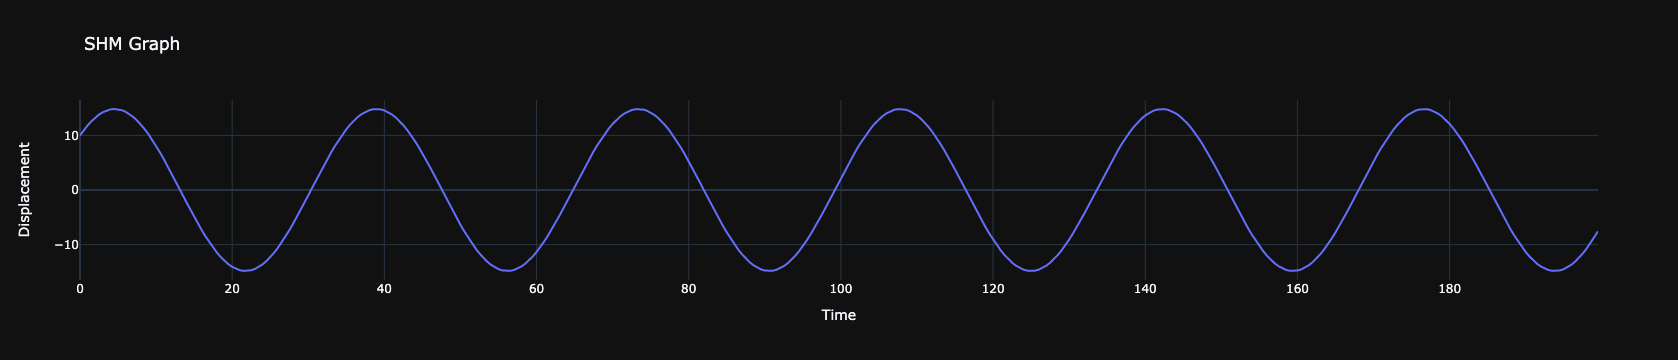

<Figure size 2160x720 with 0 Axes>

In [29]:
xo=10
vo=2
k=3
m=30*k

w=math.sqrt(k/m)
A=xo
B=vo/w

end_time=200
inc=0.5

plt.figure(figsize=(30, 10))
time=np.arange(0,end_time,inc)
data=makeTargetSet(A, B, m, k, time)

d={"Time": data[:,0], "Displacement": data[:,1]}
df = pd.DataFrame(d)

import plotly.express as px
fig = px.line(df, x="Time", y="Displacement", title='SHM Graph', template='plotly_dark')
fig.show()

In [30]:
print(f"Length of full data: {len(df)}")

Length of full data: 400


In [31]:
df

,Time,Displacement
0,0.0,10.000000
1,0.5,10.956974
2,1.0,11.822703
3,1.5,12.589978
4,2.0,13.252410
...,...,...
395,197.5,-11.626258
396,198.0,-10.738233
397,198.5,-9.760784
398,199.0,-8.702051


In [32]:
df['Displacement'].max()

14.832103337111683

In [33]:
# time_point=100 #How many samples do you want to train with?
# point=int(time_point/inc)

# train=df[:point]
# test=df[point:]

# plt.figure(figsize=(24, 6))
# plt.plot(train["Time"],train["Displacement"],'g')
# plt.plot(test["Time"],test["Displacement"],'r')

# plt.legend()
# plt.ylabel('Displacement')
# plt.xlabel('Time')

In [34]:
close_data = df['Displacement'].values
close_data = close_data.reshape((-1,1))

split_percent= 80
split_percent = split_percent/100
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Time'][:split]
date_test = df['Time'][split:]

print(f"Number of training samples: {len(close_train)}")
print(f"Number of predicting samples: {len(close_test)}")

Number of training samples: 320
Number of predicting samples: 80


In [35]:
scaler = StandardScaler()
scaler = scaler.fit(close_train)

trainSeqs = scaler.transform(close_train)

testSeqs = scaler.transform(close_test)

In [36]:
TIME_STEPS = 30
sample_predict=1

# Create the sequences of size TIME_STEPS to feed the sequential model
def to_sequences(x, y, TIME_STEPS=1):
    x_values = []
    y_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x[i:(i+TIME_STEPS)])
        y_values.append(y[i+sample_predict:(i+TIME_STEPS+sample_predict)])
        
    return np.array(x_values), np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x, y = to_sequences(trainSeqs, trainSeqs, TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x, y = to_sequences(testSeqs, testSeqs, TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [37]:
print(f"Train X shape: {trainX.shape[0]} batches, {trainX.shape[1]} values for each batch, {trainX.shape[2]} dimensional batch")
print(f"Train Y shape: {trainY.shape[0]} batches, {trainY.shape[1]} values for each batch, {trainY.shape[2]} dimensional batch")
print(f"Test X shape: {testX.shape[0]} batches, {testX.shape[1]} values for each batch, {testX.shape[2]} dimensional batch")
print(f"Test Y shape: {testY.shape[0]} batches, {testY.shape[1]} values for each batch, {testY.shape[2]} dimensional batch")

Train X shape: 92800 batches, 30 values for each batch, 1 dimensional batch
Train Y shape: 92800 batches, 30 values for each batch, 1 dimensional batch
Test X shape: 4000 batches, 30 values for each batch, 1 dimensional batch
Test Y shape: 4000 batches, 30 values for each batch, 1 dimensional batch


# Creating the Neural Network

In [41]:
print("Build model...")
#What is the shape of the output of TCN?

filter_size=3 #Use 30 for default

model = Sequential()

model.add(TCN(128, kernel_size=filter_size, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=True, activation='linear', kernel_initializer='he_normal', use_batch_norm=False, input_shape=(None, trainX.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Build model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_3 (TCN)                 (None, None, 128)         542848    
                                                                 
Total params: 542,848
Trainable params: 542,848
Non-trainable params: 0
_________________________________________________________________


In [42]:
print('Train...')
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.3, verbose=1, shuffle=True, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

Train...
Epoch 1/50
2030/2030 [==============================] - 150s 73ms/step - loss: 0.1382 - val_loss: 0.0599
Epoch 2/50
2030/2030 [==============================] - 157s 77ms/step - loss: 0.0525 - val_loss: 0.0399
Epoch 3/50
2030/2030 [==============================] - 173s 85ms/step - loss: 0.0449 - val_loss: 0.0410
Epoch 4/50
2030/2030 [==============================] - 181s 89ms/step - loss: 0.0412 - val_loss: 0.0405
Epoch 5/50
2030/2030 [==============================] - 178s 87ms/step - loss: 0.0383 - val_loss: 0.0407
Epoch 6/50
2030/2030 [==============================] - 158s 78ms/step - loss: 0.0375 - val_loss: 0.0371
Epoch 7/50
2030/2030 [==============================] - 183s 90ms/step - loss: 0.2050 - val_loss: 0.0406
Epoch 8/50
2030/2030 [==============================] - 203s 100ms/step - loss: 0.0419 - val_loss: 0.0379
Epoch 9/50
2030/2030 [==============================] - 185s 91ms/step - loss: 0.0404 - val_loss: 0.0353
Epoch 10/50
2030/2030 [======================

KeyboardInterrupt: 

In [43]:
# Plot the training and validation loss 
print("Graph Results...")
plt.figure(figsize=(40,10))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Graph Results...


NameError: name 'history' is not defined

<Figure size 2880x720 with 0 Axes>

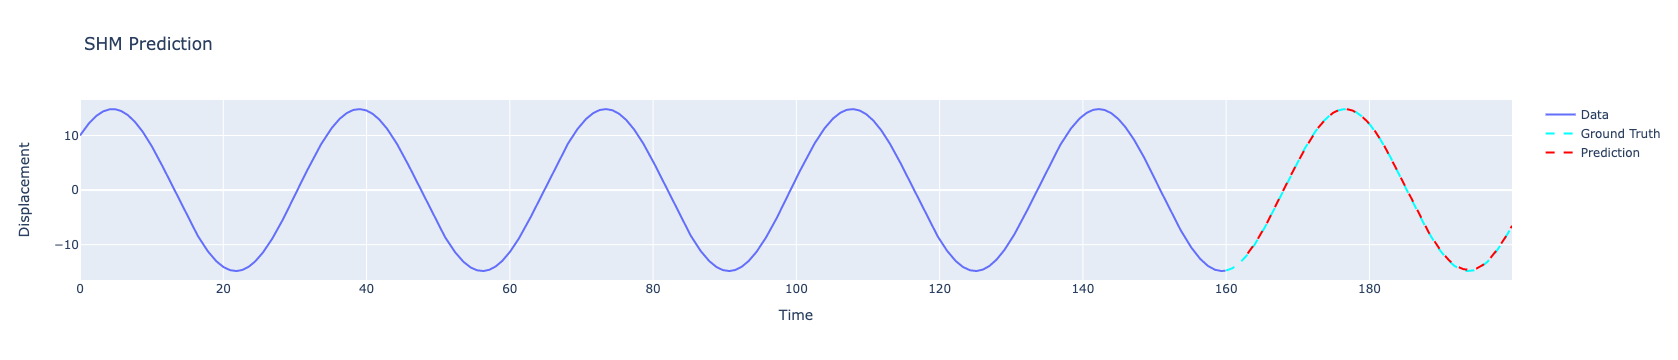

In [12]:
date_pred = date_test[look_back:]
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = close_test,
    #mode='lines',
    name = 'Ground Truth',
    line=dict(color='cyan', width=2, dash='dash')
)

trace3 = go.Scatter(
    x = date_pred,
    y = prediction,
    #mode = 'lines',
    name = 'Prediction',
    line=dict(color='red', width=2, dash='dash')
)
layout = go.Layout(
    title = "SHM Prediction",
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "Displacement"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [13]:
prediction

array([-11.62836   , -11.460326  , -11.289016  , -11.11483   ,
       -10.937857  , -10.75824   , -10.576867  , -10.393317  ,
       -10.20654   , -10.0166235 ,  -9.823528  ,  -9.625612  ,
        -9.424058  ,  -9.219392  ,  -9.011697  ,  -8.801082  ,
        -8.587403  ,  -8.3707485 ,  -8.151101  ,  -7.9284124 ,
        -7.702712  ,  -7.4720483 ,  -7.2382317 ,  -7.001411  ,
        -6.7616143 ,  -6.5190682 ,  -6.273844  ,  -6.0257926 ,
        -5.7745724 ,  -5.5195127 ,  -5.262223  ,  -5.0031905 ,
        -4.7423687 ,  -4.479583  ,  -4.216097  ,  -3.9521132 ,
        -3.689702  ,  -3.4263995 ,  -3.1644137 ,  -2.9044552 ,
        -2.6446304 ,  -2.3870988 ,  -2.1303787 ,  -1.8629595 ,
        -1.5908362 ,  -1.3200516 ,  -1.0531423 ,  -0.7943256 ,
        -0.54520917,  -0.2922157 ,  -0.03523293,   0.22483206,
         0.48615044,   0.7493055 ,   1.0157624 ,   1.2848231 ,
         1.5603796 ,   1.8424861 ,   2.1243606 ,   2.4095156 ,
         2.6981921 ,   2.9860365 ,   3.267276  ,   3.53

In [14]:
print(f"Prediction Shape: {prediction.shape}")

Prediction Shape: (370,)


1. **"close_train"** is the data set used for the training using a certain percentage to split the dataset
2. **"prediction"** speaks for itself, it is basicaly predicting what will happen on the testing data
3. **"close_test"** is the data set used for the testing using the remaining percentage to compare with the prediction, also known as the "Ground Truth"

# Forecasting

In [15]:
close_data = close_data.reshape((-1))

In [16]:
close_data.shape

(2000,)

In [17]:
def predict(num_prediction, model):
    prediction_list = close_train[-(look_back):]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [18]:
def predict_dates(num_prediction):
    prediction_dates = df['Time'][len(close_train)+1:len(close_train)+num_prediction+1] 
    return prediction_dates
    
# def predict_dates(num_prediction):
#     last_date = df['Time'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

In [19]:
num_prediction = len(close_test)-1
print(f"Number for predictions: {num_prediction}")

Number for predictions: 399


In [20]:
print("Forecast")
forecast = predict(num_prediction, model)
print(forecast)

Forecast
[-14.77452897 -14.57147121 -14.49149799 -14.4190588  -14.34484291
 -14.26482582 -14.17771912 -14.0827322  -13.97948074 -13.86772633
 -13.74728012 -13.61796188 -13.47959423 -13.330966   -13.17826939
 -13.01814461 -12.85064888 -12.67567348 -12.49301624 -12.30246162
 -12.1047163  -11.89863014 -11.68388081 -11.46161747 -11.23185158
 -10.99455261 -10.75025082 -10.49957371 -10.24290276  -9.98115826
  -9.71575356  -9.44703197  -9.16967201  -8.88670063  -8.59886646
  -8.30654144  -8.01010513  -7.71012068  -7.40694714  -7.10039711
  -6.78853846  -6.47390223  -6.15700674  -5.83813143  -5.51744652
  -5.19505024  -4.87330103  -4.55698252  -4.24650002  -3.93967295
  -3.63658071  -3.33434033  -3.0338161   -2.73754907  -2.44418621
  -2.15539122  -1.87296879  -1.5857476   -1.29374027  -1.00254023
  -0.71971756  -0.44445413  -0.17076202   0.09877719   0.36344928
   0.62585187   0.88856399   1.14992321   1.41319287   1.68371022
   1.96458697   2.25353837   2.54842401   2.85140681   3.15887594
 

In [21]:
print("Forecast Dates")
forecast_dates = predict_dates(num_prediction)
print(forecast_dates)

Forecast Dates
1601    160.1
1602    160.2
1603    160.3
1604    160.4
1605    160.5
        ...  
1995    199.5
1996    199.6
1997    199.7
1998    199.8
1999    199.9
Name: Time, Length: 399, dtype: float64


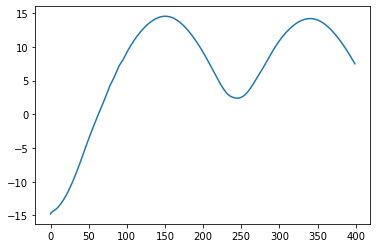

In [22]:
plt.plot(forecast)

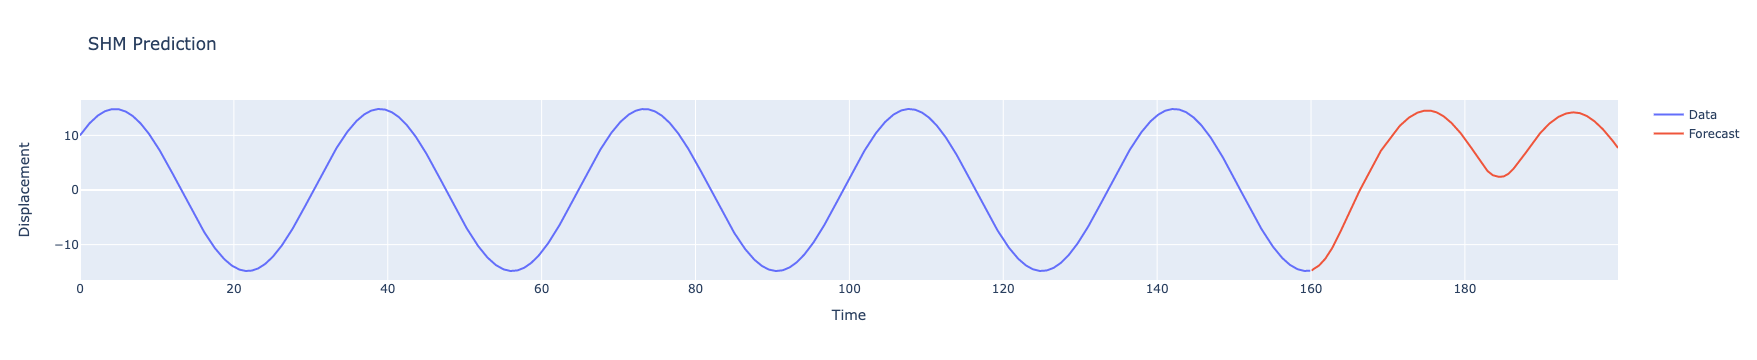

In [23]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace3 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecast'
)

layout = go.Layout(
    title = "SHM Prediction",
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "Displacement"}
)
fig = go.Figure(data=[trace1, trace3], layout=layout)
fig.show()

This prediction behavior is normal because of the propogation from the small error in the begining to propogate into a larger error during the forecast phase